# A (Hypersparse) Introduction to pygraphblas with Jupyter!

## by Michel Pelletier

## https://github.com/Graphegon/pygraphblas

## [API Documentation](https://graphegon.github.io/pygraphblas/pygraphblas/index.html)

## Tuesday and Wednesday GraphBLAS Tutorial is in Python (MT1 and MT2)

## Time is tight, please bring your API questions to the tutorial session if you can?


In [1]:
import random
from pygraphblas import *         # don't import *, use "import pygraphblas as grb"
from pygraphblas.gviz import *
from pygraphblas import lib

name = 'SIAM!!!!'
print(f'Live from {name}!')  
print(len(dir(lib)))
print(f'For SuiteSparse the biggest index is (2 ** 60): {GxB_INDEX_MAX}')

Live from SIAM!!!!!
2968
For SuiteSparse the biggest index is (2 ** 60): 1152921504606846976


In [2]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## The Graph Matrix Duality

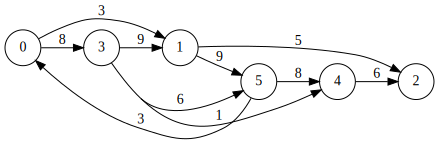

In [3]:
A = Matrix.from_lists(
    [0, 0, 1, 3, 3, 3, 5, 4, 1, 5],
    [1, 3, 2, 1, 4, 5, 0, 2, 5, 4], 
    [3, 8, 5, 9, 1, 6, 3, 6, 9, 8])

draw(A)  # talk about from_binary, from_mm, from_tsv, from_arrays, from_scipy_sparse

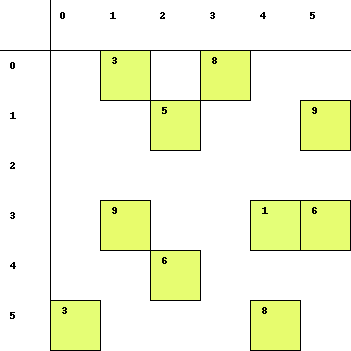

In [4]:
draw_matrix(A, scale=50, labels=True, axes_labels=True, cmap="Wistia")

## Dense, Sparse and Hypersparse

Three different uses of the term Hypersparse:

- Hypersparse data structure used by internally by SuiteSparse
- Number of stored elements less than N
- Casually meaning "GxB_INDEX_MAX dimensions"



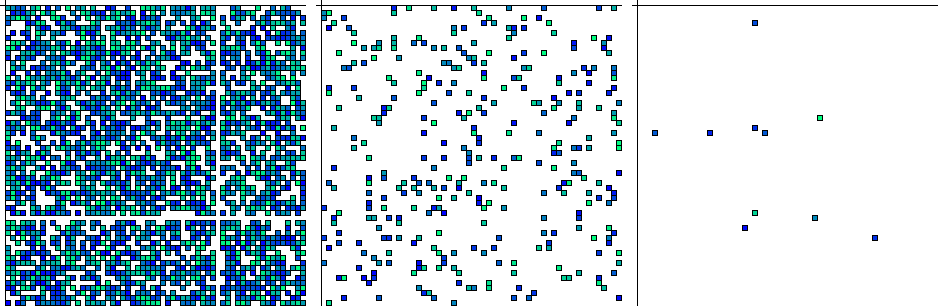

In [26]:
random.seed(43)
D = Matrix.random(FP32, 4000, 60, 60)
del D[3,2]; del D[3,3]; del D[4,2]; del D[4,3]
D[42] = Vector.sparse(FP32, 60)
D[:,42] = Vector.sparse(FP32, 60)
DR = Matrix.random(FP32, 360, 60, 60)
DHR = Matrix.random(FP32, 10, 60, 60)
draw_matrix_op(D, '', DR, DHR, scale=5, axes_labels=False, labels=False, cmap="winter", eqstr='',)

In [6]:
draw_cy(DHR.offdiag())

Cytoscape(data={'directed': True, 'elements': {'nodes': [{'data': {'id': '3'}}, {'data': {'id': '23'}}, {'data…

## Hypersparse and Matrix dimensions


(1152921504606846976, 1152921504606846976) 11


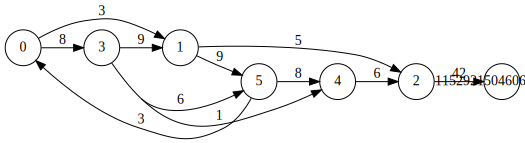

In [7]:
# pass no dimesion to go hypersparse

B = A.dup()
B.resize()
B[2, GxB_INDEX_MAX - 1] = 42
print(B.shape, len(B))
draw(B)

## BFS is Iteration of Multiplication

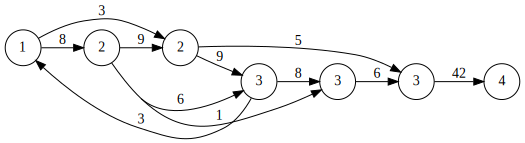

In [8]:
# Is this algorithm hypersparse?
def bfs(M, start):
    Mn = M.nrows                        # Stop after all nodes
    v = Vector.sparse(UINT8, Mn)        # the result vector
    q = Vector.sparse(BOOL, Mn)         # a vector to keep track of known nodes
    q[start] = True                     # set the starting node
    level = 1                           # set the starting level
    while q and level <= Mn:            # while there is work to do:
        v[q] = level                    #     Assign the current level to known (q) nodes in v
        v.vxm(M,                        #     v @ A
              mask=v,                   #     use known nodes as mask
              semiring=BOOL.ANY_PAIR,   #
              desc=descriptor.RC,       #     compliment the mask to only find *unknown* nodes
              out=q)                    #     update q, replace with next wavefront
        level += 1                      #     increment level
    return v

levels = bfs(B, 0)
draw_graph(B, label_vector=levels)

# Shortest Path Length

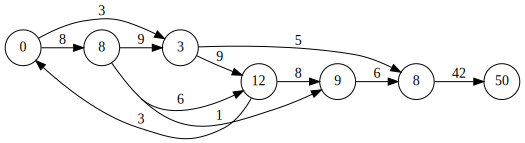

In [9]:
# is this algorithm hypersparse?

def shortest_path_length(M, start):
    v = Vector.sparse(M.type, M.nrows)      # Result vector
    v[start] = 0                            # Set starting position to 0

    with UINT8.MIN_PLUS, Accum(UINT8.MIN):  # MIN_PLUS semiring, MIN accumulator
        for _ in M.I:                       # for every hypersparse node:
            w = Vector.dup(v)               #     dup results
            v @= M                          # v @= A accumulate minimum of next level
                                            # v.vxm(matrix, out=v, accum=..., semiring=...)
            if w.iseq(v):                   #     if nothing changed:
                break                       #         we're done
        return v

draw(B, label_vector=shortest_path_length(B, 0))

# Sparse Deep Neural Networks

In [10]:
from functools import reduce
from operator import attrgetter, mul

import imageio
from IPython.core.display import Image

def permutation_matrix(size):
    P = Matrix.sparse(FP64, size, size)    
    P[size-1,0] = 1.0
    for i in range(size-1):
        P[i,i+1] = 1.0
    return P

def hypergraph(mt, frames=None, scale=1):
    size = sum(map(attrgetter('nrows'), mt)) + mt[0].nrows
    r = Matrix.sparse(FP32, size, size)
    ioffset = 0
    joffset = 0
    for m in mt:
        joffset += m.nrows
        for c, (i, j, k) in enumerate(m):
            r[i + ioffset, j + joffset] = k
        if frames is not None:
            frames.append(draw_matrix(r.pattern(), scale=scale, labels=False, cmap="Wistia"))
        ioffset += m.nrows
    return r

def mixed_topo_radix(topos, frames=None):
    sizes = [reduce(mul, x) for x in topos]
    size = sizes[0]
    layers = []
    P = permutation_matrix(size)    
    for t in topos:
        place_value = 1
        for n in t:
            layer = Matrix.sparse(FP64, size, size)
            for j in range(n):
                layer += (P ** (j*place_value))
            place_value *= n
            layers.append(layer)      
    return layers

def radixnet(topos, spec):
    return [d.kronecker(w) 
            for d, w in 
            zip(mixed_topo_radix(topos), ddnn(spec))]



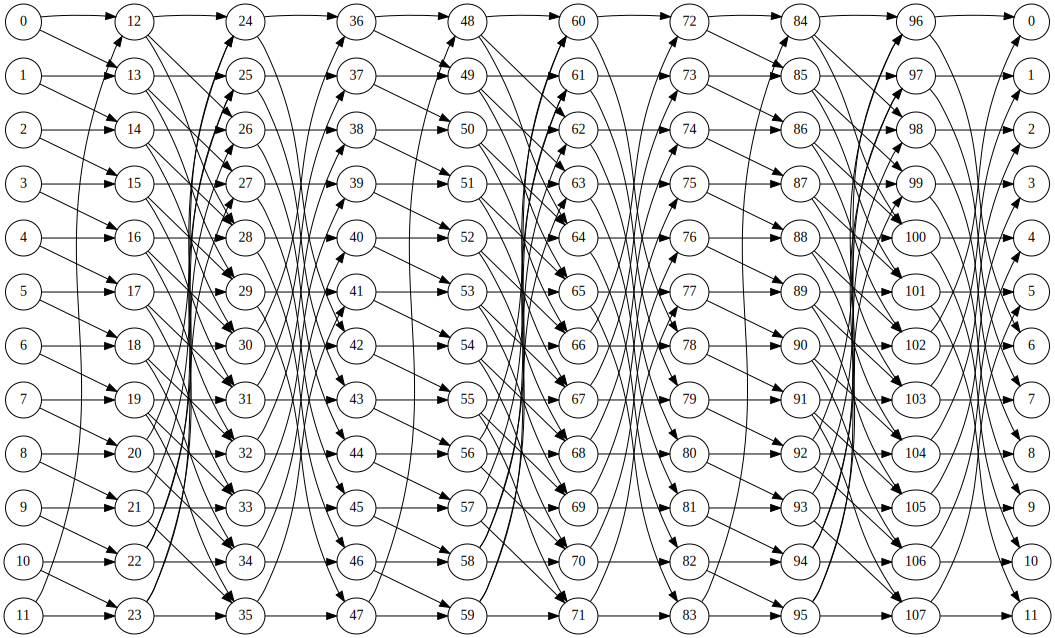

In [11]:
spec = [[2,3,2],[2,3,2],[2,3,2]]
mt = mixed_topo_radix(spec)
draw_layers(mt)

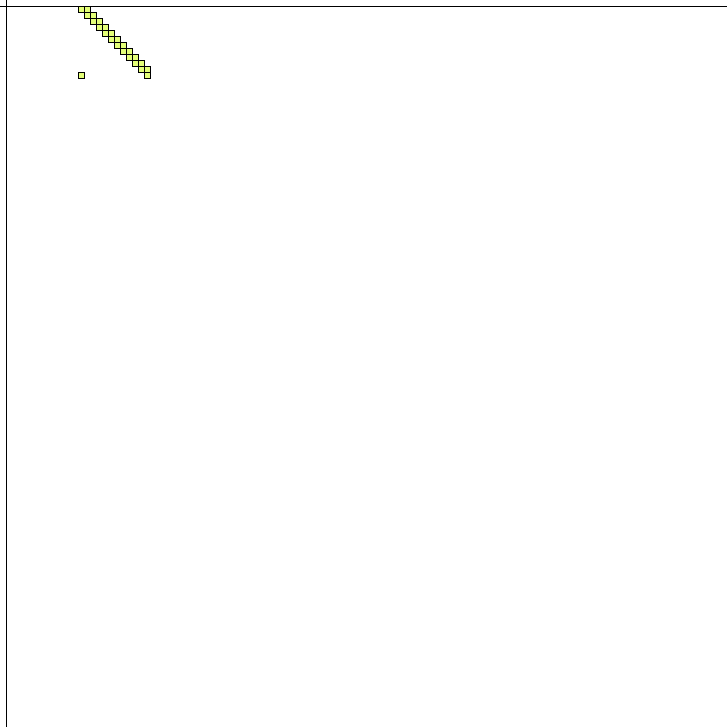

In [12]:
frames = []    
T = mixed_topo_radix(spec)
HT = hypergraph(T, frames, scale=6)
imageio.mimwrite('animated_from_images.gif', frames, fps=2)
display(Image('animated_from_images.gif'))

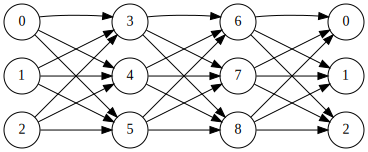

In [13]:
def ddnn(spec):
    return [Matrix.dense(FP64, spec[i], spec[i+1])
            for i in 
            range(len(spec) - 1)]

d = ddnn([3,3,3,3])
draw_layers(d)

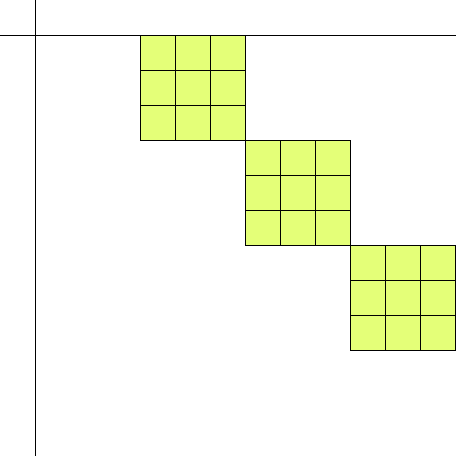

In [14]:
draw_matrix(hypergraph(d).pattern(), scale=35, cmap="Wistia", labels=False)

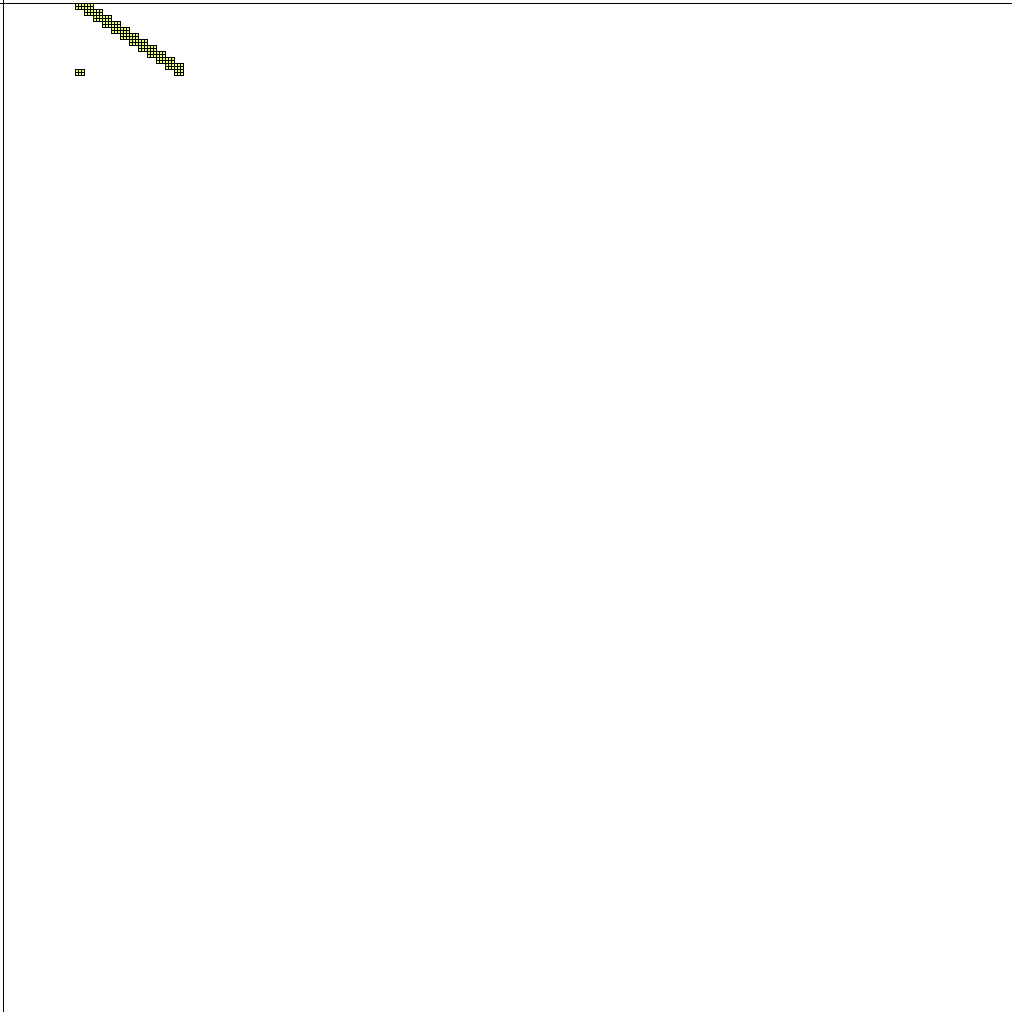

In [15]:
spec = [[2,3,2],[2,3,2],[2,3,2]]
t = [2,3,4,5,6,3,3,2]
R = radixnet(spec, t)
frames = []
HR = hypergraph(R, frames, scale=3)
imageio.mimwrite('animated_from_images.gif', frames, fps=2)
display(Image('animated_from_images.gif'))

In [16]:
spec = [[2,3,2],[2,3,2],[2,3,2]]
t = [2,3,4,5,6,3,3,2]
R = radixnet(spec, t)
HR = hypergraph(R, scale=3)
draw_cy(HR)

Cytoscape(data={'directed': True, 'elements': {'nodes': [{'data': {'id': '0'}}, {'data': {'id': '24'}}, {'data…

## Power-Law Graphs with Kronecker Powers

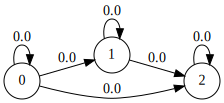

In [17]:
K = Matrix.dense(FP32, 3, 3)
K = K.triu()
draw_graph(K)

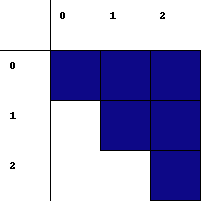

In [18]:
draw_matrix(K, scale=50, axes_labels=True, labels=False, cmap='plasma')

In [19]:
@unary_op(FP64)  
def random_uniform(x): 
    return random.uniform(0, 1)

def kronprod(K, n):
    for i in range(n-1):
        K = K.kronecker(K)
        K.apply(random_uniform, out=K)
    return K

[81, 54, 36, 27, 24, 18, 16, 12, 9, 8, 6, 4, 3, 2, 1]


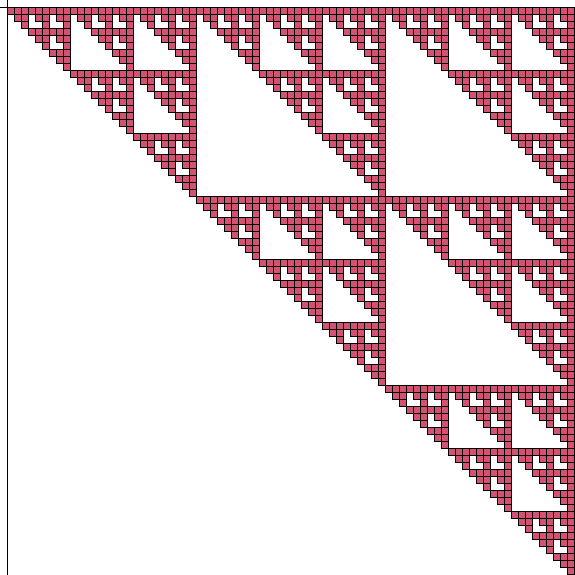

In [20]:
K4 = kronprod(K, 3)
print (sorted(set(v for i, v in K4.pattern().cast(INT64).reduce_vector()), reverse=True))
draw_matrix(K4, scale=7, cmap='plasma', labels=False)

[]


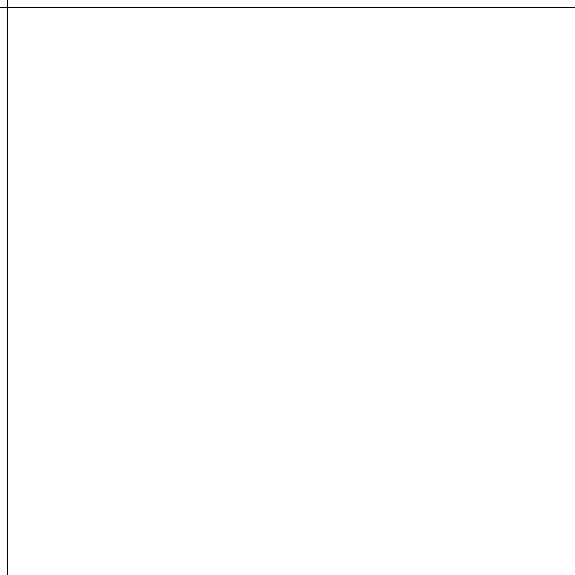

In [21]:
D = K4.select('>=', 0.66)
print (sorted(set(v for i, v in D.pattern().cast(INT64).reduce_vector()), reverse=True))
draw_matrix(D, scale=7, cmap='plasma', labels=False)

In [22]:
draw_cy(D.offdiag())

Cytoscape(data={'directed': True, 'elements': {'nodes': [], 'edges': []}}, layout_name='cose', visual_style=[{…

## Menger Sponge

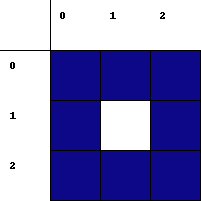

In [23]:
M = Matrix.dense(FP32, 3, 3)
del M[1, 1]
draw_matrix(M, scale=50, axes_labels=True, labels=False, cmap='plasma')

[81, 54, 36, 27, 24, 18, 16, 12, 9, 8, 6, 4, 3, 2, 1]
[81, 54, 36, 24, 16]


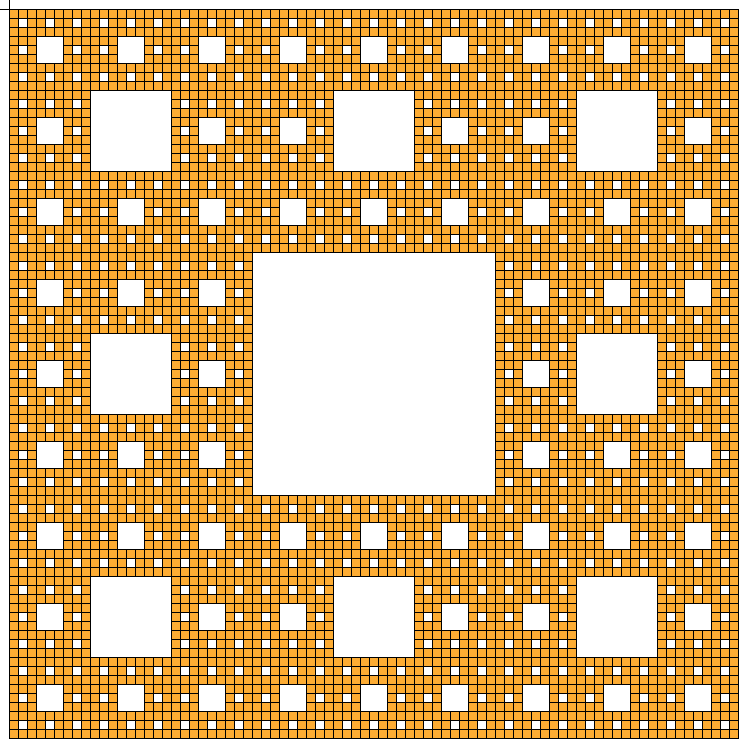

In [24]:
# menger sponge
M3 = kronprod(M, 3)

print (sorted(set(v for i, v in K4.pattern().cast(INT64).reduce_vector()), reverse=True))
print (sorted(set(v for i, v in M3.pattern().cast(INT64).reduce_vector()), reverse=True))
draw_matrix(M3, scale=9, cmap='plasma', labels=False)

# Thank you!

## Tuesday and Wednesday GraphBLAS Tutorial is in Python (MT1 and MT2)!
